In [ ]:
# Install required libraries
!pip install opencv-python-headless streamlit scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


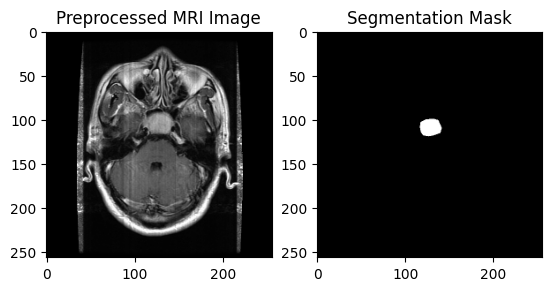

In [ ]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

# Load MRI image and mask
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

# Normalize image intensity
def normalize_image(image):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(image)

# Resize image to fixed dimensions
def resize_image(image, size=(256, 256)):
    return cv2.resize(image, size)

# Example to preprocess an image
image_path = '/content/994.png'
mask_path = '/content/991.png'

mri_image = load_image(image_path)
mask_image = load_image(mask_path)

mri_image = resize_image(mri_image)
mask_image = resize_image(mask_image)

mri_image = normalize_image(mri_image)

# Visualizing the preprocessed image and mask
plt.subplot(1, 2, 1)
plt.imshow(mri_image, cmap='gray')
plt.title("Preprocessed MRI Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_image, cmap='gray')
plt.title("Segmentation Mask")
plt.show()


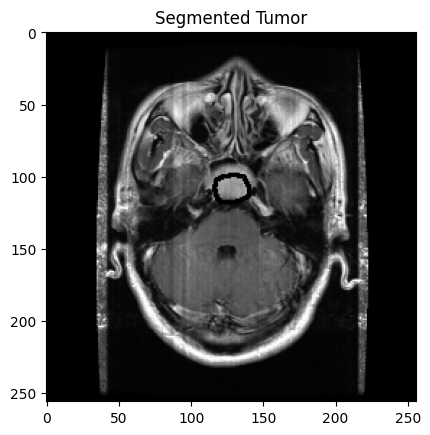

In [ ]:
# Tumor segmentation using thresholding and contours
def segment_tumor(image, mask):
    # Thresholding to get binary image
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours to identify tumor boundaries
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the MRI image
    segmented_image = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

    return segmented_image

segmented_image = segment_tumor(mri_image, mask_image)

# Visualize the result
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Tumor")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define U-Net Model
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck (Middle Layer)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Expansive path (Decoder)
    u1 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    concat1 = layers.concatenate([c5, c3], axis=-1)  # Match shapes

    u2 = layers.UpSampling2D((2, 2))(concat1)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    concat2 = layers.concatenate([c6, c2], axis=-1)  # Match shapes

    u3 = layers.UpSampling2D((2, 2))(concat2)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    concat3 = layers.concatenate([c7, c1], axis=-1)  # Match shapes

    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(concat3)

    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize and train the model
model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ up_sampling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_9[0][0],   │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ concatenate[0][0

 Total params: 7,376,321 (28.14 MB)

 Trainable params: 7,376,321 (28.14 MB)

 Non-trainable params: 0 (0.00 B)

Saving 995.png to 995.png


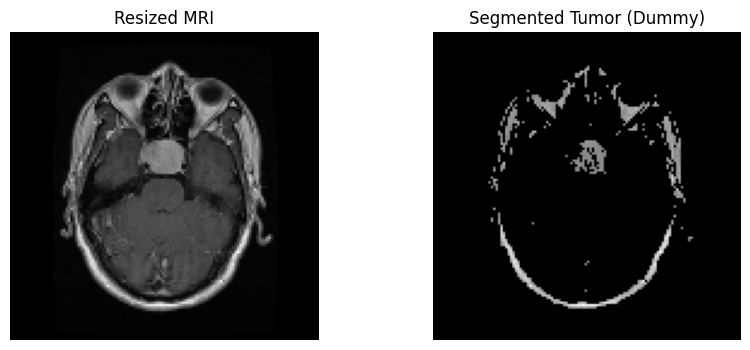

In [ ]:
import cv2
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# Upload image file manually
uploaded = files.upload()

# Load the uploaded image
for fname in uploaded.keys():
    image = Image.open(fname).convert("L")  # Convert to grayscale
    image = np.array(image)

# Resize function
def resize_image(image, size=(128, 128)):
    return cv2.resize(image, size)

# Dummy segmentation function
def segment_tumor(image):
    _, mask = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)
    segmented = cv2.bitwise_and(image, mask)
    return segmented

# Resize and segment
resized = resize_image(image)
segmented = segment_tumor(resized)

# Show results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Resized MRI")
plt.imshow(resized, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmented Tumor (Dummy)")
plt.imshow(segmented, cmap='gray')
plt.axis("off")

plt.show()


In [ ]:
pip install streamlit opencv-python pillow numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00
